# Dự đoán kết quả sống hoặc chết của hành khách trên tàu Titanic bằng mạng neural

---
## Tổng thể

Các bước xử lý:

    1/ Tiền xử lý dữ liệu
    2/ Huấn luyện Neural Network với L2 regularization (weight decay) và early stopping.

Bộ dữ liệu được sử dụng là bộ [Kaggle Titanic](https://www.kaggle.com/c/titanic). Trong đó, input là thông tin của hành khách trên tàu Titanic, output là một trong hai lớp sống/chết (1/0). 

Các file dữ liệu mà Kaggle cung cấp: `train.csv` - tập huấn luyện, `test.csv` - tập kiểm tra (chỉ có input). 

Ý nghĩa của các cột trong file `description.txt` đính kèm.

---
## Import thư viện cần thiết 
<font color=red>Lưu ý: Dùng Sklearn phiên bản > 0.19</font>.

In [1]:
import sklearn
sklearn.__version__

'0.20.1'

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.neural_network import MLPClassifier

from copy import deepcopy

---
## Đọc tập huấn luyện vào data frame và tách ra tập validation

In [3]:
data_df = pd.read_csv('train.csv', index_col=0)
data_df.head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [5]:
data_df.describe(include="all")

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,"Palsson, Master. Gosta Leonard",male,NaN,NaN,NaN,1601,NaN,C23 C25 C27,S
freq,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [6]:
# Tách X và y
y_sr = data_df["Survived"]
X_df = data_df.drop("Survived", axis=1)

In [7]:
# Tách tập train và tập validation theo tỉ lệ 70%:30%
train_X_df, val_X_df, train_y_sr, val_y_sr = train_test_split(X_df, y_sr, test_size=0.3, stratify=y_sr, random_state=0)
train_y = train_y_sr.values
val_y = val_y_sr.values

train_X_df.head().index

Int64Index([232, 837, 640, 390, 598], dtype='int64', name='PassengerId')

In [8]:
train_X_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623 entries, 232 to 81
Data columns (total 10 columns):
Pclass      623 non-null int64
Name        623 non-null object
Sex         623 non-null object
Age         496 non-null float64
SibSp       623 non-null int64
Parch       623 non-null int64
Ticket      623 non-null object
Fare        623 non-null float64
Cabin       143 non-null object
Embarked    621 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 53.5+ KB


In [9]:
val_X_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268 entries, 422 to 608
Data columns (total 10 columns):
Pclass      268 non-null int64
Name        268 non-null object
Sex         268 non-null object
Age         218 non-null float64
SibSp       268 non-null int64
Parch       268 non-null int64
Ticket      268 non-null object
Fare        268 non-null float64
Cabin       61 non-null object
Embarked    268 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 23.0+ KB


---
## Tiền xử lý tập huấn luyện

Đầu tiên, với cột `Name`, ta sẽ tiến hành rút trích ra cột `Title` tương ứng, gồm các giá trị như `Miss`, `Mrs`, `Mr`, `Master` ..., vì trong tên thì phần này có vẻ là sẽ có ích cho việc dự đoán sống/chết. Đếm số lần xuất hiện của mỗi giá trị trong cột `Title` và lưu kết quả vào biến `title_counts` (là Series với index là các giá trị có thể có của `Title`)

Lưu ý: không làm thay đổi `train_X_df`.

In [10]:
# Tạo cột Title
Title = pd.Series() 
# Duyệt từng dòng của cột Name trong train_X_df và thực hiện tách chuỗi 
# Để lấy được Miss, Mrs, Mr,... nằm sau dấu "," và trước dấu "." thì dùng split để tách và strip để xoá khoảng trắng 
for name in train_X_df['Name']: 
    Title[name] = name.split(',')[1].split('.')[0].strip()

title_counts = Title.value_counts()

In [11]:
# Test
assert len(title_counts) == 14
assert title_counts.loc["Mr"] == 357
assert title_counts.loc["Miss"] == 125
assert title_counts.loc["Mrs"] == 89
assert title_counts.loc["Master"] == 32

Class `ColDropper` (theo dạng Transfomer của Sklearn) sẽ thực hiện các công việc:
- Thêm cột `Title` vào DataFrame, trong đó ta sẽ chuyển các giá trị xuất hiện ít (không thuộc tập `["Mr", "Miss", "Mrs", "Master"]`) thành giá trị `Rare`.
- Bỏ cột `Name`.
- Bỏ cột `Cabin` vì cột này có nhiều giá thiếu, và có vẻ cột này sẽ không giúp ích được gì nhiều cho việc dự đoán sống/chết.
- Bỏ cột `Ticket` vì cột này có giá trị không phải dạng số, sẽ cần phải tốn sức để chuyển sang dạng số, và có vẻ cột này cũng sẽ không giúp ích được gì nhiều cho việc dự đoán sống/chết.

In [12]:
class ColDropper(BaseEstimator, TransformerMixin):
    def __init__(self, add_title_col=True):
        self.add_title_col = add_title_col
    def fit(self, X_df, y=None):
        return self
    def transform(self, X_df, y=None):
        X_df = X_df.copy()
        if self.add_title_col:
            title_col = X_df.Name.str.extract("([a-zA-z]+)\.", expand=False)
            non_rare_titles = ["Mr", "Miss", "Mrs", "Master"]
            title_col[~title_col.isin(non_rare_titles)] = "Rare"
            X_df["Title"] = title_col
        dropped_cols = ['Name', 'Ticket', 'Cabin']
        X_df.drop(dropped_cols, axis=1, inplace=True)
        return X_df
# Test ColDropper
col_dropper = ColDropper()
fewer_cols_train_X_df = col_dropper.fit_transform(train_X_df)
fewer_cols_train_X_df.sample(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,
357,1,female,22.0,0,1,55.0000,S,Miss
387,3,male,1.0,5,2,46.9000,S,Master
358,2,female,38.0,0,0,13.0000,S,Miss
463,1,male,47.0,0,0,38.5000,S,Mr
828,2,male,1.0,0,2,37.0042,C,Master


Đến đây, các cột dạng số gồm:`Pclass`, `Age`, `SibSp`, `Parch`, `Fare`; các cột dạng chuỗi có giá trị rời rạc không thứ tự (categorical) gồm: `Sex`, `Embarked`, `Title`. Các bước tiền xử lý tiếp theo như sau:
- Với các cột dạng số, ta sẽ điền giá trị thiếu bằng giá trị mean của cột <font color=blue>(gợi ý: dùng `SimpleImputer` trong Sklearn)</font>. Với *tất cả* các cột dạng số trong tập huấn luyện, ta đều cần tính mean; vì ta không biết được cột nào sẽ bị thiếu giá trị khi test. 
- Với các cột dạng chuỗi có giá trị rời rạc không thứ tự:
    - Ta sẽ điền giá trị thiếu bằng giá trị mode (giá trị xuất hiện nhiều nhất) của cột <font color=blue>(gợi ý: dùng `SimpleImputer` trong Sklearn)</font>. Với *tất cả* các cột dạng chuỗi có giá trị rời rạc không thứ tự trong tập huấn luyện, ta đều cần tính mode; vì ta không biết được cột nào sẽ bị thiếu giá trị khi test.
    - Sau đó, ta sẽ chuyển sang dạng số bằng phương pháp mã hóa one-hot <font color=blue>(gợi ý: dùng `OneHotEncoder` trong Sklearn)</font>.
- Cuối cùng, khi tất cả các cột đã được điền giá trị thiếu và đã có dạng số, ta sẽ tiến hành chuẩn hóa bằng cách trừ đi mean và chia cho độ lệch chuẩn của cột để giúp cho các thuật toán cực tiểu hóa như Gradient Descent, LBFGS, ... hội tụ nhanh hơn <font color=blue>(gợi ý: dùng `StandardScaler` trong Sklearn)</font>.

Nhiệm vụ tạo ra một pipeline, đặt tên là `full_preprocess_pipeline`, bao gồm: bước thêm cột `Title` và bỏ các cột (đã cài đặt ở class `ColDropper`), và tất cả các bước ở đây. Sau khi tạo ra được pipeline này rồi, gọi phương thức `fit_transform` với đầu vào là `train_X_df` để tính các tham số (ví dụ, mean và mode ở bước xử lý giá trị thiếu, mean và độ lệch chuẩn ở bước chuẩn hóa, ...) và đồng thời tiền xử lý `train_X_df`; kết quả trả về sẽ là `train_X_df` sau khi đã tiền xử lý, là một mảng Numpy, đặt tên là `preprocessed_train_X`. <font color=blue>(Gợi ý: dùng `Pipeline` hoặc `make_pipeline`trong Sklearn, có thể xem sự khác biệt của 2 cái này [ở đây](https://stackoverflow.com/questions/40708077/what-is-the-difference-between-pipeline-and-make-pipeline-in-scikit); ngoài ra, có thể dùng `ColumnTransformer` hoặc `make_column_transformer` để tạo ra một pipeline mà gồm vài pipeline thành phần, các pipeline thành phần làm trên các tập cột khác nhau trong DataFrame.)</font>

In [13]:
num_cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
cat_cols = ['Sex', 'Embarked', 'Title']

# Tạo Pipeline điền giá trị thiếu cho các cột numeric
num_transformer = Pipeline([('simple_imputer', SimpleImputer(strategy='mean', fill_value='missing'))])

# Tạo Pipeline điền giá trị thiếu và chuẩn hoá về dạng số cho các cột categorical
cat_transformer = Pipeline([('simple_imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
                            ('onehot_encoder', OneHotEncoder(handle_unknown='ignore'))])

# Tạo ColumnTransformer và truyền giá trị tên các cột vào
numcat_transformer = ColumnTransformer([('numeric', num_transformer, num_cols),
                                        ('categorical', cat_transformer, cat_cols)])

# Tạo Pipeline đầy đủ các quy trình gồm thêm cột Title -> Chuẩn hoá các cột -> StandardScaler
full_preprocess_pipeline = Pipeline([('col_dropper', ColDropper()),
                                     ('numcat_transformer', numcat_transformer),
                                     ('std_scaler', StandardScaler())])

preprocessed_train_X = full_preprocess_pipeline.fit_transform(train_X_df)

In [14]:
# Test
assert preprocessed_train_X.shape == (623, 15)
row0 = {-0.736, -0.501, -0.481, -0.48, -0.479, -0.478, -0.408, -0.295, -0.233, -0.182, -0.041, 0.603, 0.736, 0.844, 0.863}
row1 = {-0.736, -0.664, -0.501, -0.481, -0.48, -0.478, -0.463, -0.408, -0.295, -0.233, -0.182, 0.603, 0.736, 0.844, 0.863}
assert set(np.round(preprocessed_train_X[0], decimals=3)) == row0
assert set(np.round(preprocessed_train_X[1], decimals=3)) == row1

---
## Tiền xử lý tập validation

Một khi đã có `full_preprocess_pipeline` với các tham số đã được tính từ tập huấn luyện, ta có thể dễ dàng dùng phương thức `transform` để tiền xử lý cho các input mới trong tập validation và tập test. Dưới đây, làm như vậy để tiền xử lý cho `val_X_df` và lưu kết quả vào `preprocessed_val_X`.

In [15]:
preprocessed_val_X = full_preprocess_pipeline.transform(val_X_df)

In [16]:
# Test
assert preprocessed_val_X.shape == (268, 15)
row0 = {-1.659, -0.736, -0.664, -0.501, -0.481, -0.48, -0.478, -0.408, -0.233, -0.182, 0.736, 0.844, 0.863, 3.385}
row1 = {-1.988, -1.358, -1.158, -0.478, -0.408, -0.346, -0.295, -0.233, -0.182, 0.098, 0.603, 0.831, 1.358, 1.38, 1.996}
assert set(np.round(preprocessed_val_X[0], 3)) == row0
assert set(np.round(preprocessed_val_X[1], 3)) == row1

Giải thích tại sao không nên làm 2 cách sau:
- Tiền xử lý tập validation bằng các tham số của tập validation
- Hoặc tiền xử lý tất cả dữ liệu rồi mới tách tập validation

Trả lời:

1/ Không tiền xử lý tập validation bằng các tham số của tập validation vì: tập validation có dữ liệu có thể nhỏ, nếu dùng tham số tập validation để tiền xử lý thì hàm sẽ dùng mean và std của tập validation có thể gây sai lệch không đúng với thực tế. Tập train có số lượng lớn có mean và std tính tổng quát khách quan hơn nên tập validation phải scaling dựa vào mean và std của tập train.


2/ Không tiền xử lý tất cả dữ liệu rồi mới tách tập validation vì: Làm như vậy được xem là "học trước" vì đã nhìn fit vào tập validation, gây ô nhiễm tập validation. Tập validation phải như tập test hoàn toàn được giữ kín, không được đụng đến.

---
## Huấn luyện Neural Network với L2 regularization
Để thấy được ảnh hưởng của L2 regularization (weight decay) tới quá trình học, huấn luyện 5 mô hình Neural Net với 5 giá trị `alpha` khác nhau: 0.1, 1, 10, 100, 1000; các siêu tham số khác cố định như sau: `hidden_layer_sizes=(50), activation="tanh", solver="lbfgs", random_state=0`. 

Mỗi mỗi mô hình, in ra độ lỗi trên tập huấn luyện và trên tập validation. Cuối cùng, chọn mô hình tốt nhất là mô hình có độ lỗi trên tập validation nhỏ nhất; lưu mô hình này vào biến `best_l2_nnet` và lưu độ lỗi tương ứng trên tập validation vào biến `best_l2_val_err`.

In [17]:
best_l2_nnet = None
best_l2_val_err = float("inf")
for alpha in [0.1, 1, 10, 100, 1000]:
    # Tạo model
    neural_net_model = MLPClassifier(hidden_layer_sizes=(50), activation="tanh", 
                                     alpha = alpha, solver="lbfgs", 
                                     max_iter=200, random_state=0)
    
    # Huấn luyện model
    neural_net_model.fit(preprocessed_train_X, train_y_sr)
    
    # Tính độ lỗi trung bình trên tập train và tập validation
    train_err = np.mean(train_y_sr != neural_net_model.predict(preprocessed_train_X)) * 100
    val_err = np.mean(val_y_sr != neural_net_model.predict(preprocessed_val_X)) * 100
    print("alpha = {:6.1f}, train_err = {:6.2f}%, val_err = {:6.2f}%".format(alpha, train_err, val_err))
    
    # Tìm giá trị độ lỗi nhỏ nhất trên validtion, lưu lại model và độ lỗi nhỏ nhất
    if(val_err < best_l2_val_err):
        best_l2_val_err = val_err
        best_l2_nnet = neural_net_model
    
print("\nbest_l2_val_err = {:6.2f}%".format(best_l2_val_err))
# Kết quả của mình:
# alpha =    0.1, train_err =   6.42%, val_err =  20.90%
# alpha =    1.0, train_err =  11.56%, val_err =  17.91%
# alpha =   10.0, train_err =  17.50%, val_err =  16.79%
# alpha =  100.0, train_err =  19.10%, val_err =  19.40%
# alpha = 1000.0, train_err =  38.36%, val_err =  38.43%
# best_l2_val_err =  16.79%

alpha =    0.1, train_err =   6.42%, val_err =  20.90%
alpha =    1.0, train_err =  11.56%, val_err =  17.91%
alpha =   10.0, train_err =  17.50%, val_err =  16.79%
alpha =  100.0, train_err =  19.10%, val_err =  19.40%
alpha = 1000.0, train_err =  38.36%, val_err =  38.43%

best_l2_val_err =  16.79%


Hãy nhận xét và giải thích kết quả.

* Nhận xét: Độ lỗi giảm dần từ alpha = 0.1 và đến alpha = 10.0 thì độ lỗi nhỏ nhất trong tập alpha. Sau đó độ lỗi tăng dần đến khi alpha = 1000.0


* Giải thích: Với alpha là siêu tham số cho biết mức độ kìm hãm:
    + Nếu alpha quá lớn thì mô hình sẽ bị kìm hãm quá mức, không fit được nhiễu nhưng cũng không fit được tín hiệu thật sự dẫn tới underfit ===> Tương ứng với alpha = 1000
    + Nếu alpha quá bé thì có thể sẽ không đủ để kìm hãm mô hình, mô hình có thể sẽ fit vào nhiễu dẫn tới bị overfit ===> Tương ứng với alpha = 0.1
    + Vậy với alpha = 10 là trung dung vừa có thể kìm hãm nhiễu, vừa có thể fit được tín hiệu thật

---
## Huấn luyện Neural Network với early stopping

Để thí nghiệm early stopping, ta sẽ huấn luyện Neural Net với 200 vòng lặp và chọn ra mô hình có độ lỗi nhỏ nhất trên tập validation; các siêu tham số khác cố định như sau: `alpha=0, hidden_layer_sizes=(50), activation="tanh", solver="lbfgs", random_state=0`. Lưu mô hình tốt nhất vào biến `best_es_nnet` và độ lỗi tương ứng trên tập validation vào biến `best_es_val_err`. Cần lưu độ lỗi trên tập huấn luyện sau mỗi epoch vào biến `train_errs` (là một list, `len(train_errs)=200`); làm tương tự cho độ lỗi trên tập validation với biến `val_errs`.

Trong Sklearn, để có thể can thiệp vào sau mỗi vòng lặp trong quá trình huấn luyện, có thể tạo `MLPClassifier` với siêu tham số `max_iter=1` và `warm_start=True`. Sau đó, có thể tự viết một vòng lặp, ở mỗi vòng lặp thì gọi phương thức `fit`; `warm_start=True` sẽ lấy các giá trị tham số ở trước đó làm điểm bắt đầu của phương thức `fit`, chứ không khởi tạo lại từ đầu nữa. Mình có thử so sánh cho `max_iter=200` và lặp 1 lần với cho `max_iter=1` và lặp 200 lần thì thấy cách đầu cho độ lỗi trên tập huấn luyện thấp hơn; nguyên nhân có thể là do thuật toán LBFGS bình thường có sử dụng các thông tin ở các bước đi trước để giúp ra quyết định tốt hơn về bước đi ở thời điểm hiện tại, nhưng mỗi khi gọi phương thức `fit` thì thuật toán LBFGS bị reset lại, các thông tin về các bước đi trước không còn nữa. Tuy nhiên, tạm thời ở đây sẽ bỏ qua vấn đề này.

Ngoài ra, trong quá trình huấn luyện, để lưu lại mô hình với các giá trị tham số hiện tại, có thể dùng hàm `deepcopy`

In [18]:
nnet = MLPClassifier(hidden_layer_sizes=(50), activation="tanh",
                     solver="lbfgs", alpha=0, random_state=0, 
                     max_iter=1, warm_start=True)
max_iter = 200
best_es_nnet = None
best_es_val_err = float("inf")
val_errs = []
train_errs = []

for iteration in range(max_iter):
    # Huấn luyện model
    nnet.fit(preprocessed_train_X, train_y_sr)
    
    # Tính độ lỗi trung bình trên tập train và tập validation
    train_errs.append(np.mean(train_y_sr != nnet.predict(preprocessed_train_X)) * 100)
    val_errs.append(np.mean(val_y_sr != nnet.predict(preprocessed_val_X)) * 100)
    
    # Tìm giá trị độ lỗi nhỏ nhất trên validtion, lưu lại model và độ lỗi nhỏ nhất
    if(val_errs[iteration] < best_es_val_err):
        best_es_val_err = val_errs[iteration]
        best_es_nnet = deepcopy(nnet)
    
print("best_es_val_err = {:5.2f}%".format(best_es_val_err))
# Kết quả của mình:
# best_es_val_err = 15.67%

best_es_val_err = 15.67%


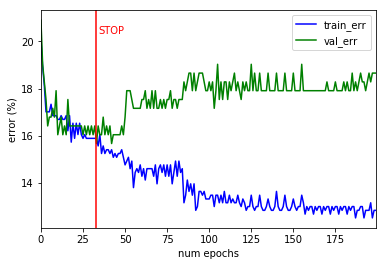

In [19]:
# Trực quan hóa quá trình huấn luyện với early stopping
plt.plot(train_errs, "b", label="train_err")
plt.plot(val_errs, "g", label="val_err")
plt.legend()
plt.xlim(0, len(train_errs)-1)
min_y, max_y = plt.ylim()
plt.ylim(min_y, max_y)
plt.xlabel("num epochs")
plt.ylabel("error (%)")
best_iter = np.argmin(val_errs)
plt.plot([best_iter, best_iter], [min_y, max_y], "r")
plt.text(best_iter + 1, max_y - 1, 'STOP', color="r");

Hãy nhận xét và giải thích về đồ thị kết quả ở trên.

* Nhận xét: Mô hình trên có vạch đỏ thể hiện điểm dừng được dừng lại tại chỗ độ lỗi trên tập validation có xu hướng tăng lên và chọn mô hình trước thời điểm đó làm mô hình huấn luyện, ban đầu độ lỗi tập validation giảm xuống đáng kể sau quá trình học một lúc và dần ổn định nhưng càng về sau thì độ lỗi có xu hướng tăng lên.


* Giải thích: Với sau mỗi vòng lặp thì độ lỗi trên tập train sẽ càng giảm và tập validation sẽ càng giảm nhưng càng về sau độ lỗi trên tập validation tăng lên còn tập train thì giảm xuống chứng tỏ mô hình đã bị overfitting nên việc làm early stopping để mô hình dừng lại trước khi overfit xảy ra, vì vậy khi độ lỗi trên validation có xu hướng tăng thì lập tức dừng lại

---
## Kiểm tra

Trong hai mô hình `best_l2_nnet` và `best_es_nnet`, chọn mô hình có độ lỗi nhỏ nhất trên tập validation là mô hình cuối cùng (của mình là mô hình `best_es_nnet`). Sau đó, dùng `full_preprocess_pipeline` + mô hình này để dự đoán với các input trong tập test (file "test.csv") và submit kết quả dự đoán lên Kaggle. Để có thể submit thì phải tạo ra file csv có 2 cột: cột thứ nhất là id của các hành khách trong tập test, cột thứ hai là giá trị dự đoán (1 - sống, và 0 - chết).

In [20]:
# Load tập test
test_X_df = pd.read_csv('test.csv', index_col=0)

# Chọn mô hình có độ lỗi nhỏ nhất
if (best_l2_val_err <= best_es_val_err):
    predict_model = best_l2_nnet
else:
    predict_model = best_es_nnet

# Tiền xử lý
preprocessed_test_X = full_preprocess_pipeline.transform(test_X_df)

# Dự đoán
test_y_sr = predict_model.predict(preprocessed_test_X)

# Tạo file my_preds.cvs
my_preds = pd.DataFrame(test_X_df.index)
my_preds['Survived'] = test_y_sr
my_preds.to_csv('my_preds.csv', encoding='utf-8', index=False)

Kế đến, submit file csv chứa kết quả dự đoán lên [Kaggle](https://www.kaggle.com/c/titanic) (cần tạo một account trên Kaggle), và ghi nhận lại độ lỗi trên tập test ở cell phía dưới.

My Score: 0.80382

<img src="my_predict_score.PNG">